#Imports

In [1]:
import urllib.request
import os
import numpy as np
import csv
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import re, string
import nltk
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from wordcloud import WordCloud


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Read dataset

In [3]:
df_test = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_test.csv")
df_train = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_train.csv")

In [4]:
df_train.head()

,id,text,irony,sarcasm,topic,lemmatized_text,cleaned_text,cleaned_text_mention_hashtag
0,8.111568e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...
1,8.111831e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...
2,8.263806e+17,"Zingari..i soliti ""MERDOSI""..#cacciamolivia Ro...",0.0,0.0,HSC,zingaro solito merdoso #cacciamolivia Roma rom...,zingari soliti merdosi #cacciamolivia roma rom...,zingari soliti merdosi @hashtag roma rom aggre...
3,8.448712e+17,"Zingari di merda,tutti al muro...bastardi Spar...",0.0,0.0,HSC,zingaro merda muro bastardo sparare carabinier...,zingari merda muro bastardi sparano carabinier...,zingari merda muro bastardi sparano carabinier...
4,5.097128e+17,zero notizie decreto #tfaordinario II ciclo ze...,1.0,0.0,TW-BS,zero notizia decreto #tfaordinario II ciclo ze...,zero notizie decreto #tfaordinario ii ciclo ze...,zero notizie decreto @hashtag ii ciclo zero no...
...,...,...,...,...,...,...,...,...
3972,1.366107e+17,Casini:Trovare un'intesa tra forze politiche o...,0.0,0.0,TW-SENTIPOLC,Casini trovare intendere forza politico oppost...,casini trovare intesa forze politiche opposte ...,casini trovare intesa forze politiche opposte ...
3973,1.465388e+17,Cambiare tutto per non cambiare niente sembra ...,0.0,0.0,TW-SENTIPOLC,cambiare cambiare niente sembrare linea politi...,cambiare cambiare niente sembra linea politica...,cambiare cambiare niente sembra linea politica...
3974,1.557581e+17,Alcuni mettono mani nelle tasche degli italian...,0.0,0.0,TW-SENTIPOLC,alcun mettere mano tasca italiano evasore risp...,alcuni mettono mani tasche italiani evasori ri...,alcuni mettono mani tasche italiani evasori ri...
3975,8.368583e+17,A parte che la dieta di #Salvini dovrebbe ess...,1.0,0.0,HSC,parte dieta #Salvini dovere rigorosamente pada...,parte dieta #salvini dovrebbe rigorosamente pa...,parte dieta @hashtag dovrebbe rigorosamente pa...


In [ ]:
X_train = df_train['cleaned_text']
X_train_lem = df_train['lemmatized_text']
X_train_men_has = df_train['cleaned_text_mention_hashtag']

y_train = df_train['irony'].values

In [ ]:
len(X_train),len(y_train)

(3977, 3977)

In [ ]:
X_test = df_test['cleaned_text']
X_test_lem = df_test['lemmatized_text']
X_test_men_has = df_test['cleaned_text_mention_hashtag']

y_test = df_test['irony'].values

In [ ]:
len(X_test),len(y_test)

(872, 872)

Positive and Negative labels are balanced?

In [ ]:
print("Ratio of positive instances in the train set: %0.2f" % (( len(y_train) - sum(y_train) ) / len(y_train)))

Ratio of positive instances in the train set: 0.49


In [ ]:
print("Percentage of positive instances in the test set: %0.2f" % (( len(y_test) - sum(y_test) ) / len(y_test)))

Percentage of positive instances in the test set: 0.50


#Irony Classification

In [ ]:
table = []
table_lem = []
table_men_has = []

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def nltk_ngram_tokenizer(text):
    tt= TweetTokenizer()
    all_tokens = list()

    tokens = tt.tokenize(text)


    # we use a simple nltk function to create ngrams
    if len(tokens) >= 2:
      bigrams = ['BI_'+w1+'_'+w2 for w1,w2 in nltk.ngrams(tokens,2)]
      trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(tokens,3)]
      all_tokens.extend(bigrams)
      all_tokens.extend(trigrams)

    all_tokens.extend(tokens)

    return all_tokens

# SVC

## cleaned text

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=200)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train, y_train)
X_test_tok= pipe.transform(X_test)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 200) (872, 200)


In [ ]:
param_grid=[{
    'C':[0.1, 1, 10, 100], 
    'kernel':[ 'linear']
    },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale','auto'], 
    'kernel':['rbf']
     },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale', 'auto'], 
    'kernel':[ 'poly'],
    'degree': [1, 2, 3, 4, 5]
    }
]

In [ ]:
grid= GridSearchCV(SVC(random_state=0), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(random_state=0),
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}],
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
clf= SVC(C=100, degree=1, gamma='auto', kernel='rbf',  random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.68      0.80      0.73      1658
         1.0       0.83      0.73      0.78      2319

    accuracy                           0.76      3977
   macro avg       0.75      0.76      0.75      3977
weighted avg       0.77      0.76      0.76      3977



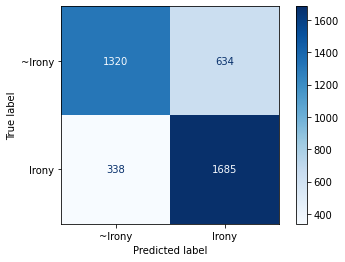

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.54      0.75      0.63       315
         1.0       0.82      0.64      0.72       557

    accuracy                           0.68       872
   macro avg       0.68      0.69      0.67       872
weighted avg       0.72      0.68      0.68       872



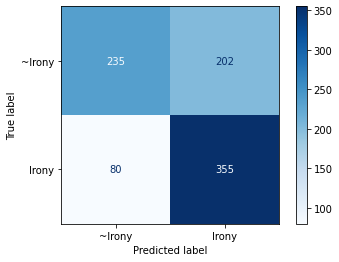

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table.append({'SVC':d})

## lemmatized text

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=200)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train_lem, y_train)
X_test_tok= pipe.transform(X_test_lem)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 200) (872, 200)


In [ ]:
param_grid=[{
    'C':[0.1, 1, 10, 100], 
    'kernel':[ 'linear']
    },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale','auto'], 
    'kernel':['rbf']
     },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale', 'auto'], 
    'kernel':[ 'poly'],
    'degree': [1, 2, 3, 4, 5]
    }
]

In [ ]:
grid= GridSearchCV(SVC(random_state=0), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(random_state=0),
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}],
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
clf= SVC(C=100, gamma='auto', kernel='rbf', random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73      1630
         1.0       0.85      0.73      0.78      2347

    accuracy                           0.76      3977
   macro avg       0.76      0.77      0.76      3977
weighted avg       0.78      0.76      0.76      3977



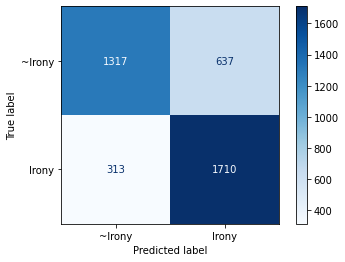

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.53      0.75      0.62       309
         1.0       0.83      0.64      0.72       563

    accuracy                           0.68       872
   macro avg       0.68      0.70      0.67       872
weighted avg       0.72      0.68      0.69       872



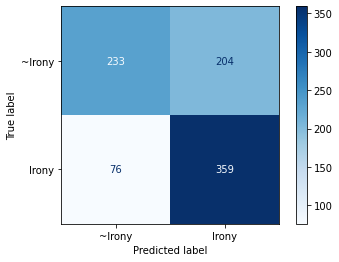

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_lem.append({'SVC':d})

## cleaned_text_mention_hashtag

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=200)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train_men_has, y_train)
X_test_tok= pipe.transform(X_test_men_has)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 200) (872, 200)


In [ ]:
param_grid=[{
    'C':[0.1, 1, 10, 100], 
    'kernel':[ 'linear']
    },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale','auto'], 
    'kernel':['rbf']
     },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale', 'auto'], 
    'kernel':[ 'poly'],
    'degree': [1, 2, 3, 4, 5]
    }
]

In [ ]:
grid= GridSearchCV(SVC(random_state=0), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(random_state=0),
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}],
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'C': 10, 'kernel': 'linear'}

In [ ]:
clf= SVC(C=10, kernel='linear', random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72      1846
         1.0       0.76      0.72      0.74      2131

    accuracy                           0.73      3977
   macro avg       0.73      0.73      0.73      3977
weighted avg       0.73      0.73      0.73      3977



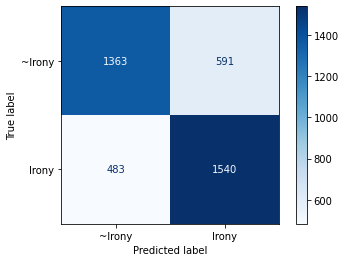

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.62      0.69      0.66       396
         1.0       0.72      0.66      0.68       476

    accuracy                           0.67       872
   macro avg       0.67      0.67      0.67       872
weighted avg       0.68      0.67      0.67       872



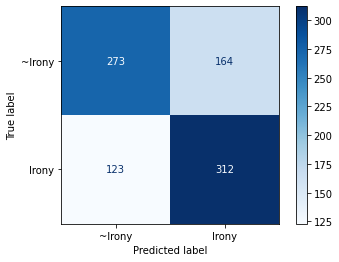

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_men_has.append({'SVC':d})

#Decision Tree

## cleaned_text

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=500)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train, y_train)
X_test_tok= pipe.transform(X_test)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 500) (872, 500)


In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

In [ ]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.71      0.77      0.73      1801
         1.0       0.79      0.74      0.76      2176

    accuracy                           0.75      3977
   macro avg       0.75      0.75      0.75      3977
weighted avg       0.75      0.75      0.75      3977



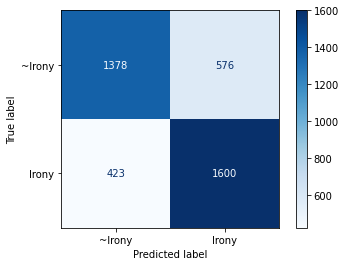

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.55      0.73      0.63       331
         1.0       0.79      0.64      0.71       541

    accuracy                           0.67       872
   macro avg       0.67      0.68      0.67       872
weighted avg       0.70      0.67      0.68       872



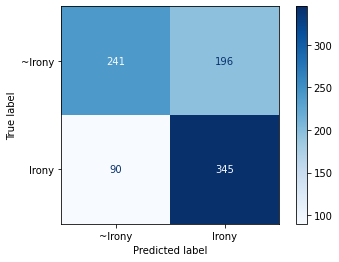

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table.append({'DT':d})

Inspect the tree

In [ ]:
selector= pipe.named_steps['selbestk']
vect= pipe.named_steps['vect']

In [ ]:
features_names = [i for (i, v) in zip(vect.get_feature_names(), selector.get_support()) if v]
len(features_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


500

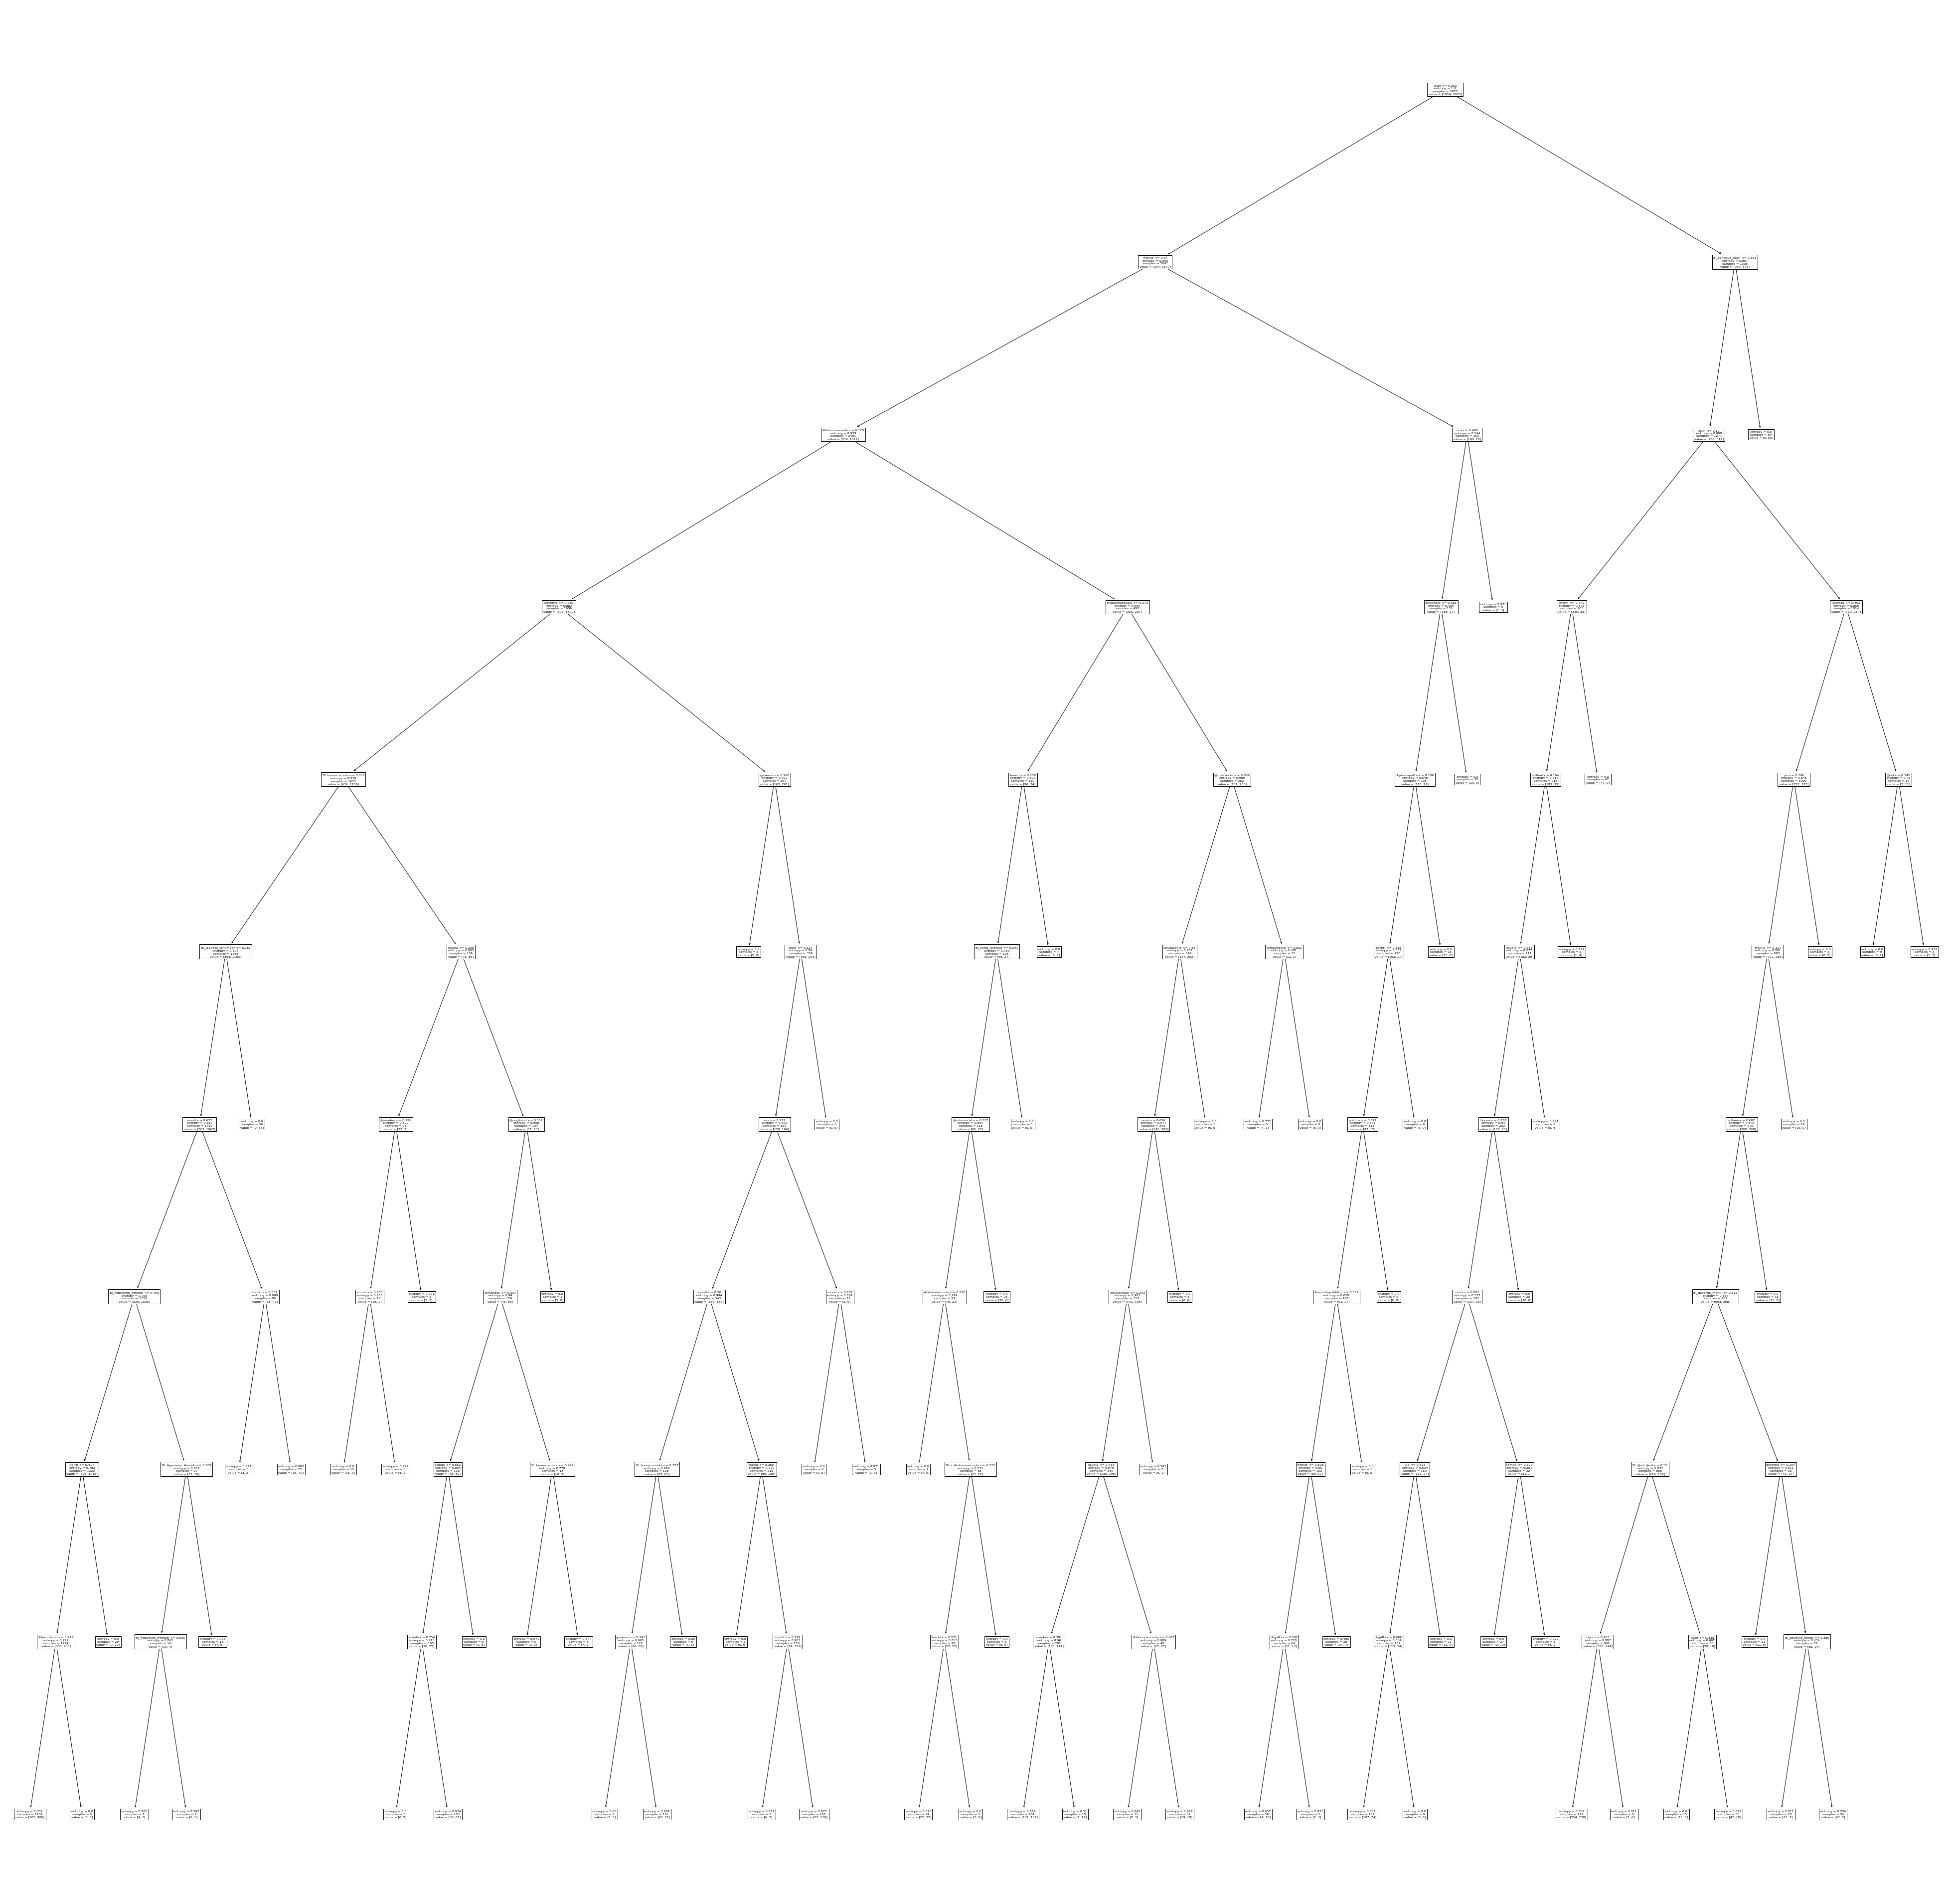

In [ ]:
fig, ax = plt.subplots(figsize=(70, 70))
plot_tree(clf, feature_names=features_names)
plt.show()

## lemmatized_text

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=500)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train_lem, y_train)
X_test_tok= pipe.transform(X_test_lem)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 500) (872, 500)


In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 55}

In [ ]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth=10, min_samples_leaf=5, min_samples_split=55, random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.67      0.78      0.72      1675
         1.0       0.82      0.72      0.76      2302

    accuracy                           0.74      3977
   macro avg       0.74      0.75      0.74      3977
weighted avg       0.75      0.74      0.74      3977



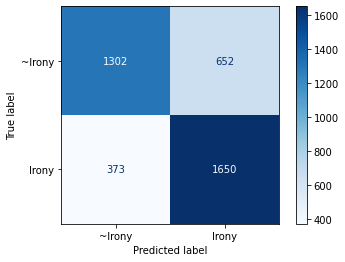

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.53      0.73      0.62       318
         1.0       0.80      0.63      0.71       554

    accuracy                           0.67       872
   macro avg       0.67      0.68      0.66       872
weighted avg       0.71      0.67      0.67       872



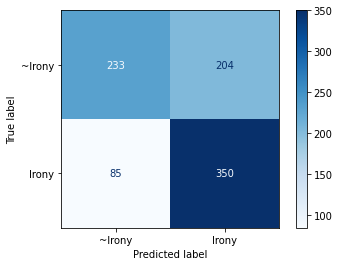

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_lem.append({'DT':d})

Inspect the tree

In [ ]:
selector= pipe.named_steps['selbestk']
vect= pipe.named_steps['vect']

In [ ]:
features_names = [i for (i, v) in zip(vect.get_feature_names(), selector.get_support()) if v]
len(features_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


500

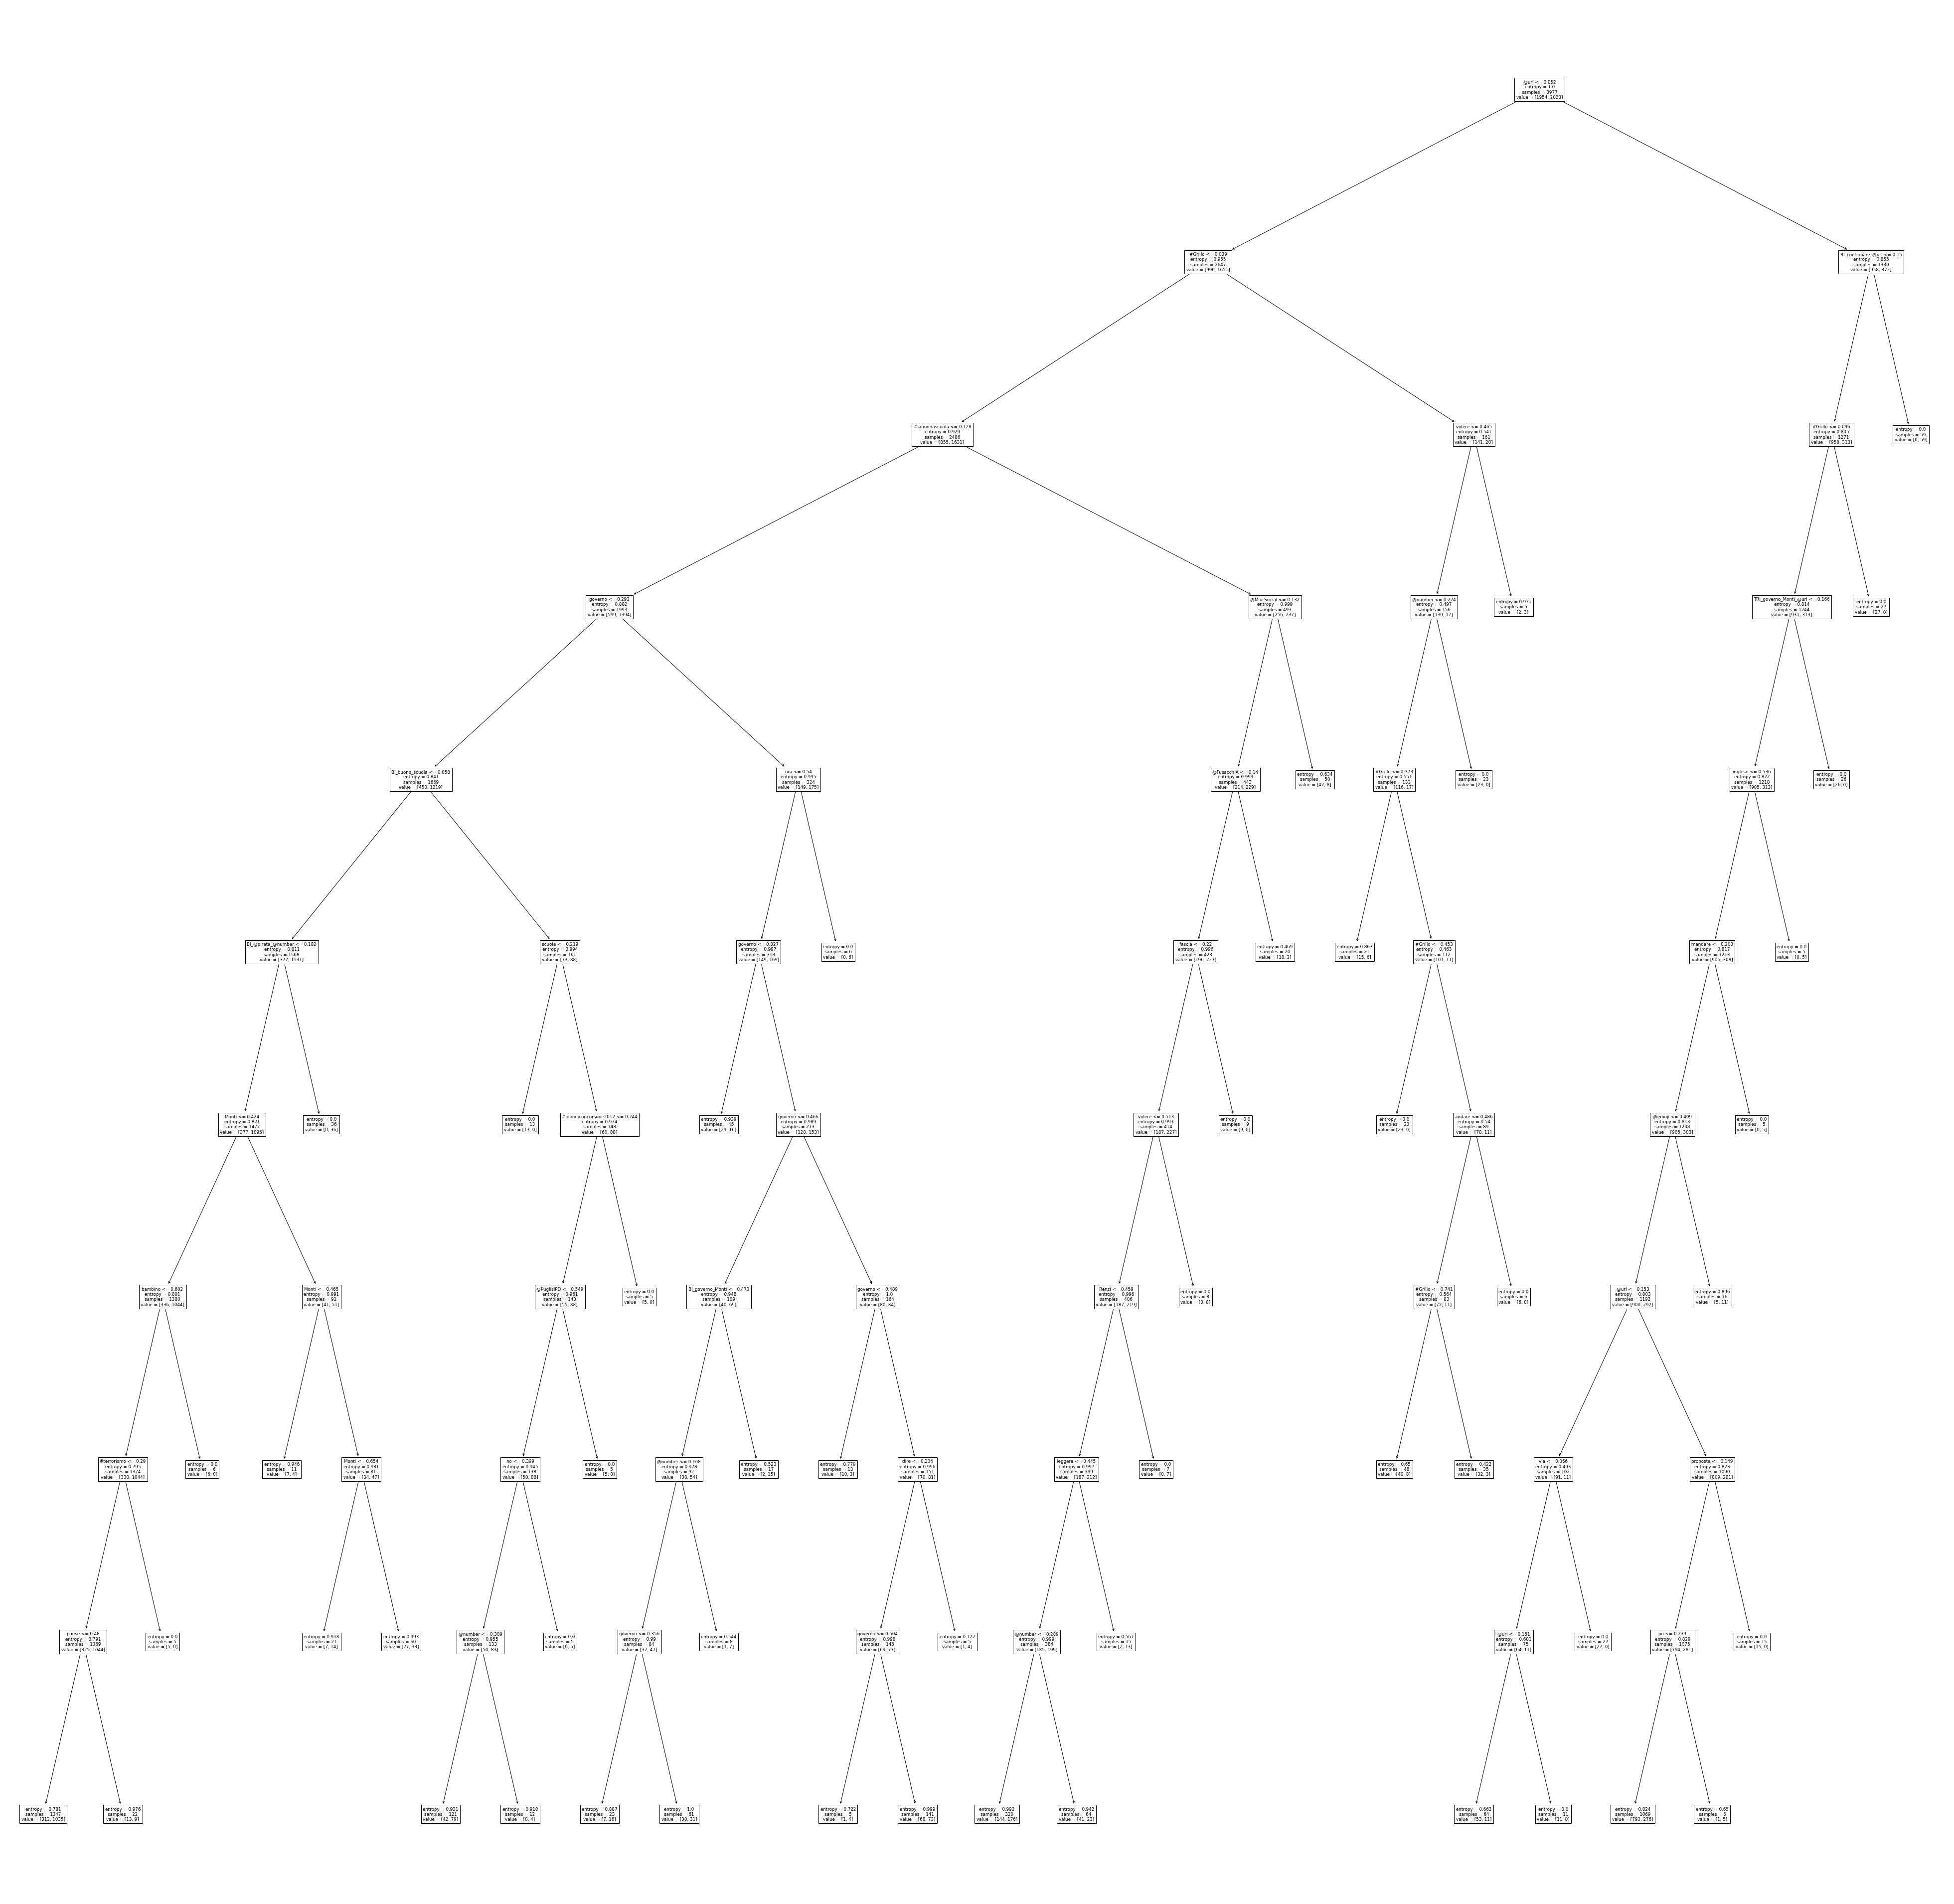

In [ ]:
fig, ax = plt.subplots(figsize=(70, 70))
plot_tree(clf, feature_names=features_names)
plt.show()

## cleaned_text_mention_hashtag


In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=500)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train_men_has, y_train)
X_test_tok= pipe.transform(X_test_men_has)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 500) (872, 500)


In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 15}

In [ ]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth=10, min_samples_leaf=5, min_samples_split=15, random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.59      0.77      0.67      1509
         1.0       0.83      0.68      0.74      2468

    accuracy                           0.71      3977
   macro avg       0.71      0.72      0.71      3977
weighted avg       0.74      0.71      0.72      3977



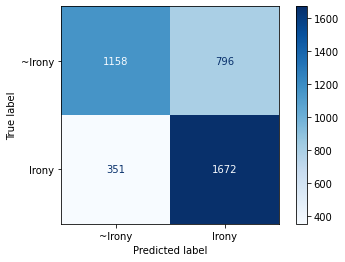

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.59      0.72      0.64       358
         1.0       0.77      0.65      0.70       514

    accuracy                           0.68       872
   macro avg       0.68      0.68      0.67       872
weighted avg       0.69      0.68      0.68       872



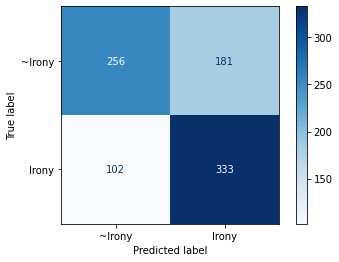

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_men_has.append({'DT':d})

Inspect the tree

In [ ]:
selector= pipe.named_steps['selbestk']
vect= pipe.named_steps['vect']

In [ ]:
features_names = [i for (i, v) in zip(vect.get_feature_names(), selector.get_support()) if v]
len(features_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


500

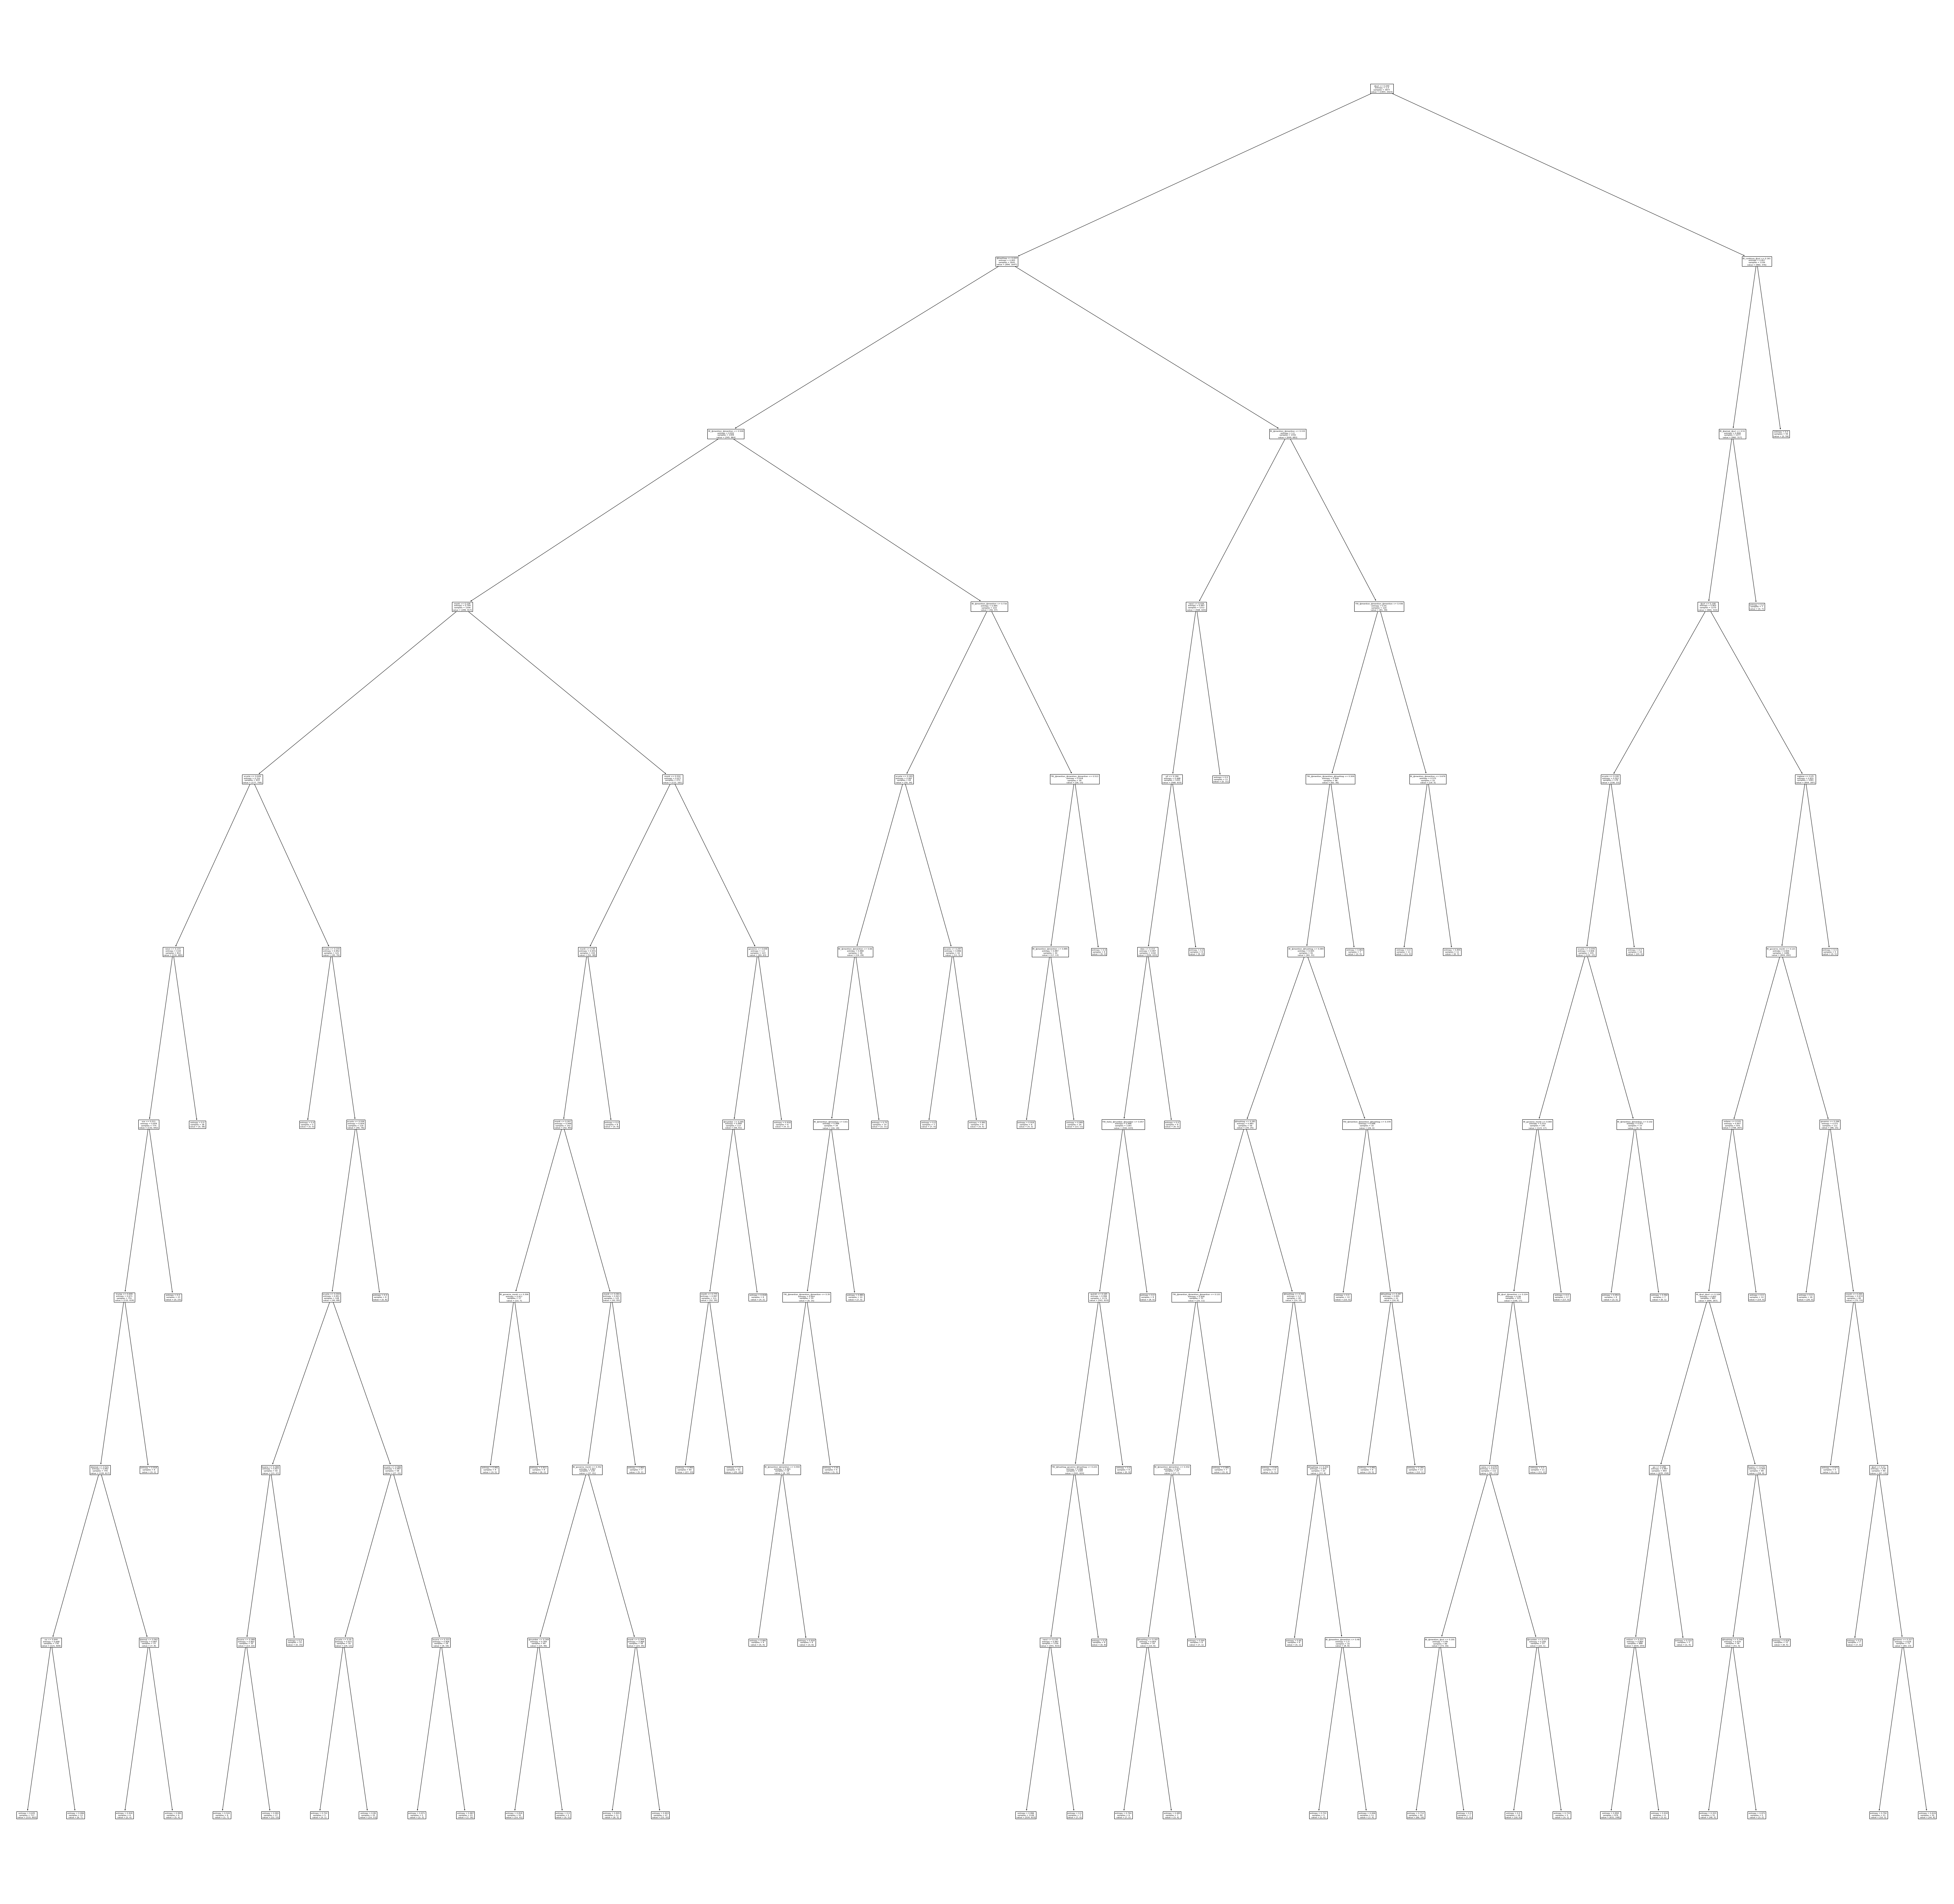

In [ ]:
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(clf, feature_names=features_names)
plt.show()

# Naive Bayes

## cleaned_text

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=300)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train, y_train)
X_test_tok= pipe.transform(X_test)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 300) (872, 300)


In [ ]:
param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

In [ ]:
grid= GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)},
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 0.01}

In [ ]:
clf = MultinomialNB(alpha=0.01)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.81      0.74      0.77      2137
         1.0       0.72      0.80      0.76      1840

    accuracy                           0.76      3977
   macro avg       0.77      0.77      0.76      3977
weighted avg       0.77      0.76      0.77      3977



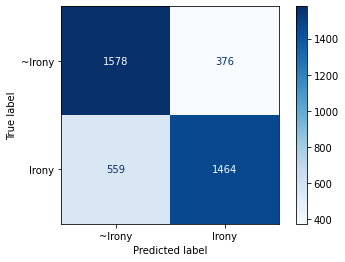

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63       411
         1.0       0.67      0.63      0.65       461

    accuracy                           0.64       872
   macro avg       0.64      0.64      0.64       872
weighted avg       0.64      0.64      0.64       872



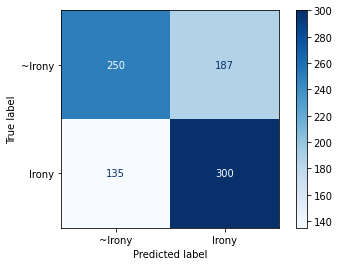

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table.append({'NB':d})

## lemmatized_text

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=300)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train_lem, y_train)
X_test_tok= pipe.transform(X_test_lem)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 300) (872, 300)


In [ ]:
param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

In [ ]:
grid= GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)},
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 0.1}

In [ ]:
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75      2025
         1.0       0.74      0.76      0.75      1952

    accuracy                           0.75      3977
   macro avg       0.75      0.75      0.75      3977
weighted avg       0.75      0.75      0.75      3977



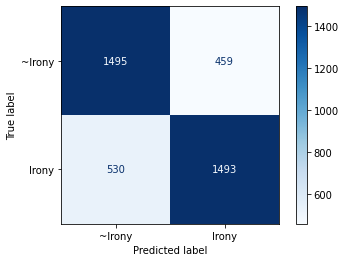

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.54      0.68      0.60       351
         1.0       0.74      0.62      0.67       521

    accuracy                           0.64       872
   macro avg       0.64      0.65      0.64       872
weighted avg       0.66      0.64      0.64       872



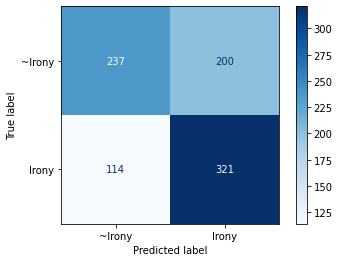

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_lem.append({'NB':d})

## cleaned_text_mention_hashtag

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=300)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train_men_has, y_train)
X_test_tok= pipe.transform(X_test_men_has)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 300) (872, 300)


In [ ]:
param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

In [ ]:
grid= GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)},
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 0.001}

In [ ]:
clf = MultinomialNB(alpha=0.001)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73      1995
         1.0       0.73      0.74      0.73      1982

    accuracy                           0.73      3977
   macro avg       0.73      0.73      0.73      3977
weighted avg       0.73      0.73      0.73      3977



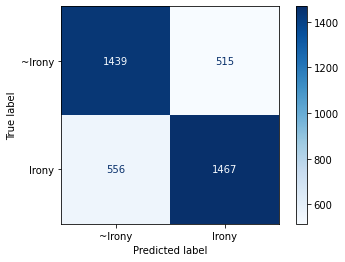

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.61      0.66      0.64       407
         1.0       0.68      0.64      0.66       465

    accuracy                           0.65       872
   macro avg       0.65      0.65      0.65       872
weighted avg       0.65      0.65      0.65       872



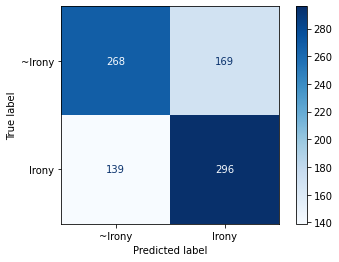

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result = classification_report(y_test, y_pred_test, target_names=['~Irony','Irony'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_men_has.append({'NB':d})

# Results

In [ ]:
recap = pd.DataFrame()
for dic in table:
  recap = pd.concat([recap, pd.DataFrame.from_dict(dic, orient='index')])

In [ ]:
recap

,~Irony,Irony,macro avg
SVC,0.625000,0.715726,0.670363
DT,0.627604,0.706967,0.667286
NB,0.627358,0.647321,0.637340


In [ ]:
recap_lemm = pd.DataFrame()
for dic in table_lem:
  recap_lemm= pd.concat([recap_lemm, pd.DataFrame.from_dict(dic, orient='index')])

In [ ]:
recap_lemm

,~Irony,Irony,macro avg
SVC,0.624665,0.719439,0.672052
DT,0.617219,0.707786,0.662502
NB,0.601523,0.671548,0.636535


In [ ]:
recap_men_has = pd.DataFrame()
for dic in table_men_has:
  recap_men_has = pd.concat([recap_men_has, pd.DataFrame.from_dict(dic, orient='index')])

In [ ]:
recap_men_has

,~Irony,Irony,macro avg
SVC,0.655462,0.684962,0.670212
DT,0.644025,0.701791,0.672908
NB,0.635071,0.657778,0.646424
